In [644]:
from sympy import init_session
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.integrate as it
from scipy.signal import savgol_filter


init_session(use_latex = True)

IPython console for SymPy 1.13.2 (Python 3.10.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [645]:
# Size
a = 1.78 * 0.0254 #m R2
b = 12.1 * 0.0254 #m R3
c = 3.17 * 0.0254 #m R4
d = 13.4 * 0.0254 #m R1
a, b, c, d

In [646]:
m = 3.48 #kg
l = 24.5 * 0.0254 #length of wiper m
I = 1/3 * m * l**2 + m * (l/2 * sqrt(3))**2 + 1/3 * m * (l/2)**2 #moment of inertia about com kgm^2 
mu_k = 0.3  # coefficien()t of kinetic friction
g = 9.81  # gravity (m/s^2)
theta = 25 #degs
n = 3 # order of polynomial filtering 
b = 53 # window size for filter need to be odd number
I

In [647]:
#Parameters
motor_torque = 30 #NM 
df = pd.read_csv("4bardata.txt", sep='\t' , header = None, names = ["time [s]", "theta_2 [rad]", "theta_3 [rad]", "theta_4 [rad]", "theta_2 [°]","theta_3 [°]","theta_4 [°]","omega_2 [rad/s]", "omega_3 [rad/s]","omega_4 [rad/s]","alpha_2 [rad/s^2]","alpha_3 [rad/s^2]","alpha_4 [rad/s^2]"])


In [648]:
#Torque Calculations

tau_out = []
err = 15 # to eliminate spikes and use small angle approximation
for i in range(df.shape[0]):
    theta_a = 180.0 - df["theta_2 [°]"][i] + df["theta_3 [°]"][i] # inner angle between link a and b
    theta_b = df["theta_4 [°]"][i]- df["theta_3 [°]"][i] # inner angle between link b and c
    if abs(theta_a) > err and abs(theta_a) < (180-err):
        temp1 = motor_torque * ((c * np.sin(np.deg2rad(theta_b)))/ (a * np.sin(np.deg2rad(theta_a))))
        tau_out.append(temp1)
    elif abs(theta_b) < err and abs(theta_a) > (180-err):
        temp2 = motor_torque * (c * np.sin(np.deg2rad(theta_b)))/ (a * theta_a)
        tau_out.append(temp2)
    else: 
        temp3 = motor_torque * (c* np.sin(np.deg2rad(theta_b)))/ (a* theta_a)
        tau_out.append(temp3)

filter_tau_out = savgol_filter(tau_out, b, n)
tau_c = np.linspace(-motor_torque / 2,motor_torque  / 2,301)
df["Input_torque [nm]"] = tau_out
print(df["Input_torque [nm]"].to_string())

0        0.263062
1        0.263062
2        0.269377
3        0.276222
4        0.283616
5        0.291573
6        0.300097
7        0.309188
8      188.724631
9      149.974850
10     125.300497
11     108.307182
12      95.959396
13      86.631348
14      79.374009
15      73.596420
16      68.911603
17      65.055758
18      61.843065
19      59.139035
20      56.844114
21      54.883208
22      53.198790
23      51.746236
24      50.490616
25      49.404436
26      48.466038
27      47.658476
28      46.968731
29      46.387193
30      45.907387
31      45.525912
32      45.242624
33      45.061125
34      44.989671
35      45.042704
36      45.243395
37      45.627852
38      46.252253
39      47.205302
40      48.630866
41      50.771172
42      54.054517
43      59.288066
44       1.176136
45       1.465227
46       2.081470
47       3.925275
48      38.282838
49      -5.453242
50      -2.777549
51      -1.995436
52      -1.636275
53     -83.208139
54     -76.217440
55     -71

In [649]:
# Equations of Motion
acceleration_t = []
force_spring = []
alpha_w = []
F_n = []
F_friction = []

for i in range(df.shape[0]):
    temp7 = (df["Input_torque [nm]"][i] / 2) * ( 1 / (I - 0.25 * m * l**2))  #alpha
    #temp7 = (df["Input_torque [nm]"][i] / I)   #alpha
    alpha_w.append(temp7)
    
    temp8 = alpha_w[i] * l / 2 #use a = r*alpha to find alpha
    acceleration_t.append(temp8)
    
    temp9 = (df["Input_torque [nm]"][i] / l) - (m * l * alpha_w[i] / 2)#friction
    F_friction.append(temp8)

    temp10 = F_friction[i] / mu_k #Normal force
    F_n.append(temp10)
    
    temp11 = F_n[i] - m * g * np.cos(np.radians(theta)) #Spring Force
    force_spring.append(temp11)
    
df["F_normal [N]"] = F_n
df["Friction [N]"] = F_friction
df["acc_tan [m/s^2]"] = acceleration_t 
df["alpha_w [rad/s^2]"] = alpha_w
df["F_spring [N]"]= force_spring
df.head()


,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_3 [rad/s],omega_4 [rad/s],alpha_2 [rad/s^2],alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N]
0,0.00,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,0.0,0.121798,29.960644,0.263062,0.110429642511935,0.0331288927535805,0.0331288927535805,0.106472417655730,-30.8298306375749
1,0.01,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,0.0,0.121798,29.960644,0.263062,0.110429642511935,0.0331288927535805,0.0331288927535805,0.106472417655730,-30.8298306375749
2,0.02,0.0681,0.254700,1.546965,3.901843,14.593232,88.634560,6.81,-1.031730,-0.733699,0.0,0.805461,30.537016,0.269377,0.113080844423672,0.0339242533271016,0.0339242533271016,0.109028614260330,-30.8271794356631
3,0.03,0.1362,0.244433,1.541161,7.803685,14.004996,88.302003,6.81,-1.020598,-0.426671,0.0,1.406589,30.819922,0.276222,0.115954316750094,0.0347862950250281,0.0347862950250281,0.111799116262343,-30.8243059633367
4,0.04,0.2043,0.234307,1.538436,11.705528,13.424778,88.145894,6.81,-1.003890,-0.118261,0.0,1.920327,30.815159,0.283616,0.119058303409331,0.0357174910227992,0.0357174910227992,0.114791872160692,-30.8212019766775


In [650]:
#Use trapezoidal rule to find v by integration
dt = 0.0001
v_tan = it.cumulative_trapezoid(df["acc_tan [m/s^2]"], df["time [s]"], initial = 0)
omega_w = it.cumulative_trapezoid(df["alpha_w [rad/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
df["vel_tan [m/s]"] = v_tan
df["omega_w [rad/s]"] = omega_w


In [651]:
#Use trapezoidal rule to find position by integration
dt = 0.01
tan = it.cumulative_trapezoid(df["vel_tan [m/s]"], dx = dt, initial = 0)
theta_w = it.cumulative_trapezoid(df["omega_w [rad/s]"], x = df["time [s]"],dx = dt, initial = 0)
df["pos_tan [m]"] = tan 
df["pos_angular [rad]"] = theta_w
df["pos_angular [°]"] = (theta_w * 180 /np.pi) % 360

In [652]:
df.head()


,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_3 [rad/s],omega_4 [rad/s],...,F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N],vel_tan [m/s],omega_w [rad/s],pos_tan [m],pos_angular [rad],pos_angular [°]
0,0.00,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,...,0.110429642511935,0.0331288927535805,0.0331288927535805,0.106472417655730,-30.8298306375749,0,0,0,0,0.0
1,0.01,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,...,0.110429642511935,0.0331288927535805,0.0331288927535805,0.106472417655730,-30.8298306375749,0.000331288927535805,0.00106472417655730,1.65644463767903e-6,5.32362088278652e-6,0.000305021008311377
2,0.02,0.0681,0.254700,1.546965,3.901843,14.593232,88.634560,6.81,-1.031730,-0.733699,...,0.113080844423672,0.0339242533271016,0.0339242533271016,0.109028614260330,-30.8271794356631,0.000666554657939216,0.00214222933613760,6.64566256505413e-6,2.13583884462611e-5,0.00122374551517174
3,0.03,0.1362,0.244433,1.541161,7.803685,14.004996,88.302003,6.81,-1.020598,-0.426671,...,0.115954316750094,0.0347862950250281,0.0347862950250281,0.111799116262343,-30.8243059633367,0.00101010739969986,0.00324636798875097,1.50289728532495e-5,4.83013750707039e-5,0.00276746493622974
4,0.04,0.2043,0.234307,1.538436,11.705528,13.424778,88.145894,6.81,-1.003890,-0.118261,...,0.119058303409331,0.0357174910227992,0.0357174910227992,0.114791872160692,-30.8212019766775,0.00136262632993900,0.00437932293086614,2.68926415014439e-5,8.64298296687895e-5,0.00495206446405622


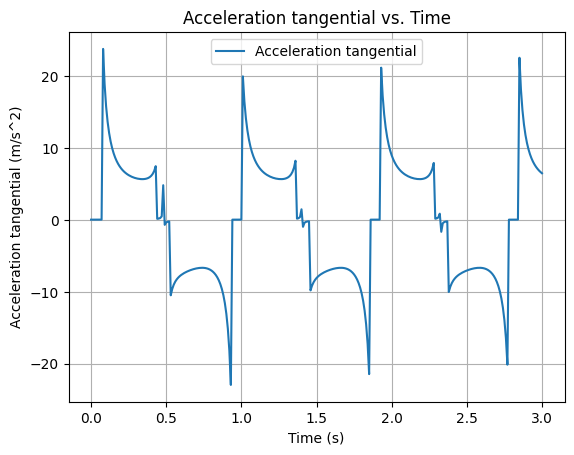

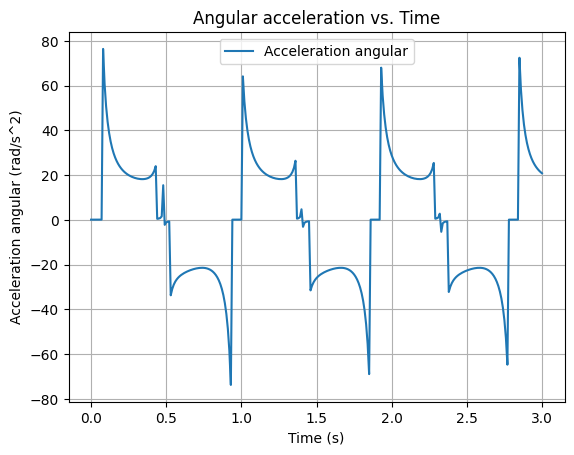

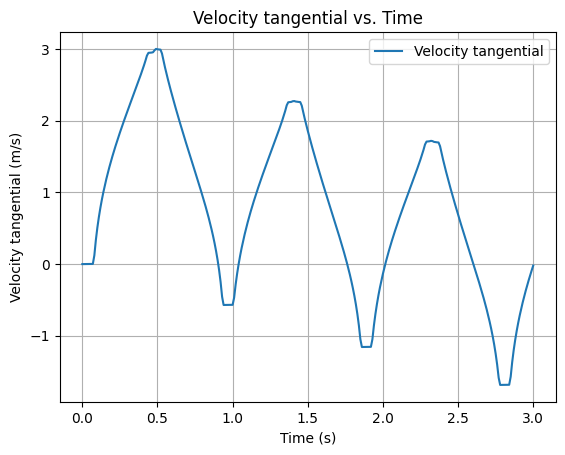

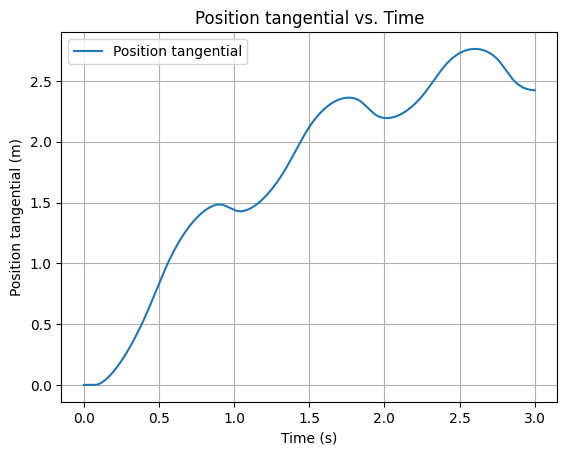

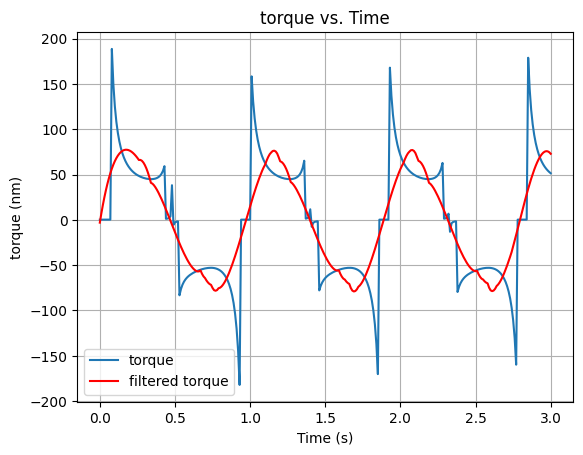

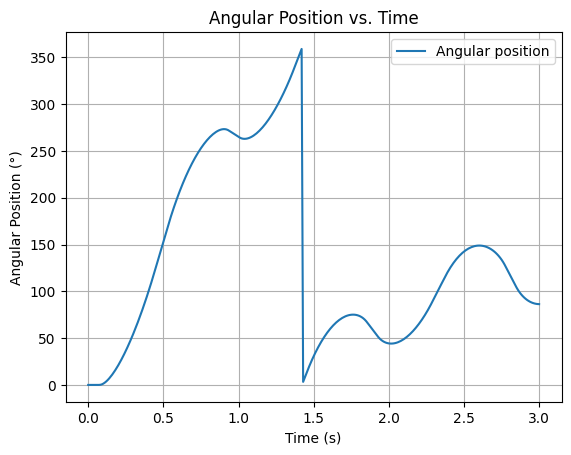

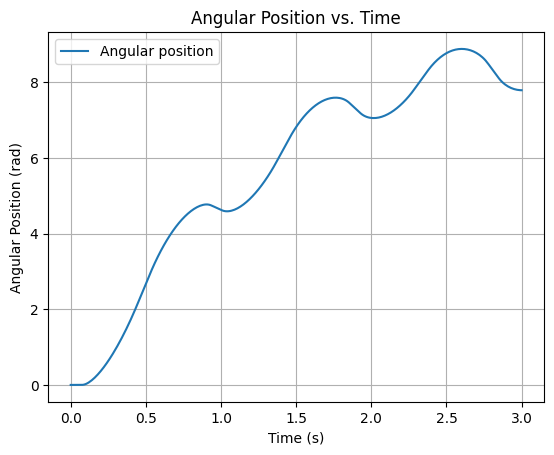

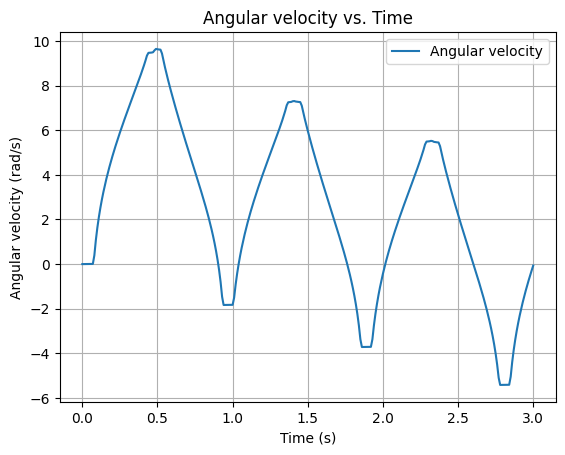

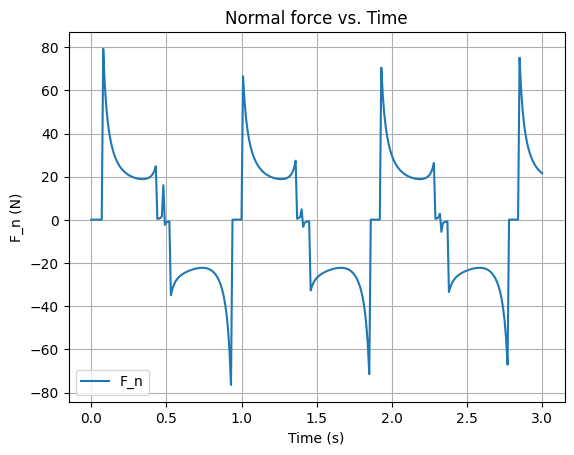

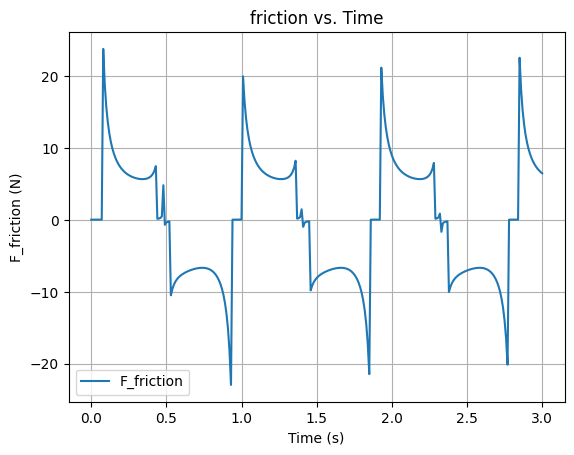

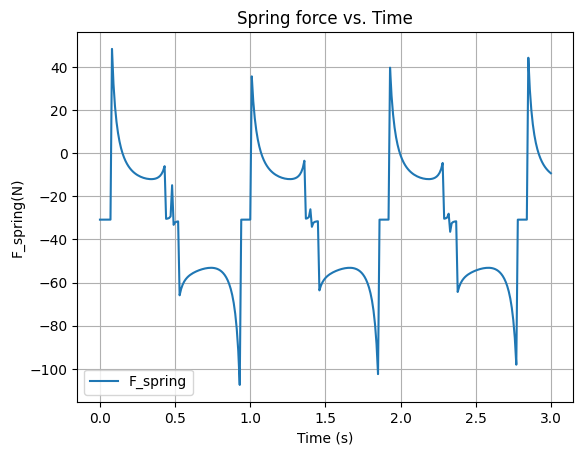

In [653]:
# Plotting the graphs

plt.plot(df["time [s]"], df["acc_tan [m/s^2]"], label='Acceleration tangential')
#plt.plot(df["time [s]"], l * df["alpha_4 [rad/s^2]"], label='FR Acceleration', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration tangential (m/s^2)')
plt.title('Acceleration tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["alpha_w [rad/s^2]"], label='Acceleration angular')
#plt.plot(df["time [s]"], df["alpha_4 [rad/s^2]"], label='ang accel fr fr ', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration angular (rad/s^2)')
plt.title('Angular acceleration vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["vel_tan [m/s]"] , label='Velocity tangential')
plt.xlabel('Time (s)')
plt.ylabel('Velocity tangential (m/s)')
plt.title('Velocity tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_tan [m]"] , label='Position tangential')
plt.xlabel('Time (s)')
plt.ylabel('Position tangential (m)')
plt.title('Position tangential vs. Time')
plt.legend()
plt.grid()
plt.show()


plt.plot(df["time [s]"], tau_out, label='torque')
plt.xlabel('Time (s)')
plt.ylabel('torque (nm)')
plt.title('torque vs. Time')

plt.grid()
yhat = savgol_filter(df["Input_torque [nm]"], b, n) # window size b, polynomial order n
plt.plot(df["time [s]"], yhat, label = 'filtered torque', color = 'red')
plt.legend()
plt.show()

plt.plot(df["time [s]"], df["pos_angular [°]"] , label='Angular position')
plt.xlabel('Time (s)')
plt.ylabel('Angular Position (°)')
plt.title('Angular Position vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_angular [rad]"] , label='Angular position')
plt.xlabel('Time (s)')
plt.ylabel('Angular Position (rad)')
plt.title('Angular Position vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["omega_w [rad/s]"] , label='Angular velocity')
plt.xlabel('Time (s)')
plt.ylabel('Angular velocity (rad/s)')
plt.title('Angular velocity vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_normal [N]"], label='F_n')
plt.xlabel('Time (s)')
plt.ylabel('F_n (N)')
plt.title('Normal force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["Friction [N]"], label='F_friction')
plt.xlabel('Time (s)')
plt.ylabel('F_friction (N)')
plt.title('friction vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_spring [N]"], label='F_spring')
plt.xlabel('Time (s)')
plt.ylabel('F_spring(N)')
plt.title('Spring force vs. Time')
plt.legend()
plt.grid()
plt.show()

